# Run inference on pre-trained model:

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from tqdm.auto import tqdm


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <B5FD9895-F13C-386E-85C3-E2998159857E> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/libpyg.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warnings.warn(f"An issue occurred while imp

In [2]:
from grace.base import GraphAttrs
from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor
from grace.models.datasets import dataset_from_graph
from grace.evaluation.visualisation import plot_simple_graph


/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <6A7076EE-85BD-37A7-BC35-1D4867F2B3D3> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Read some real grace-annotated data:

In [3]:
extractor_filename = "/Users/kulicna/Desktop/classifier/extractor/resnet152.pt"
pre_trained_resnet = torch.load(extractor_filename)
feature_extractor = FeatureExtractor(model=pre_trained_resnet)


In [4]:
# grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/train"
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(
    image_dir=grace_path, 
    grace_dir=grace_path, 
    transform=feature_extractor,
    keep_node_unknown_labels=False, 
    keep_edge_unknown_labels=False, 
    
)

In [5]:
# image, graph_data = dataset[1]
image, graph_data = dataset[0]

G = graph_data["graph"]
image = image.numpy()
annot = graph_data["annotation"]
G.number_of_nodes(), G.number_of_edges(), annot.shape, image.shape 

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(189, 552, (3724, 3724), (3724, 3724))

### Visualise the data:

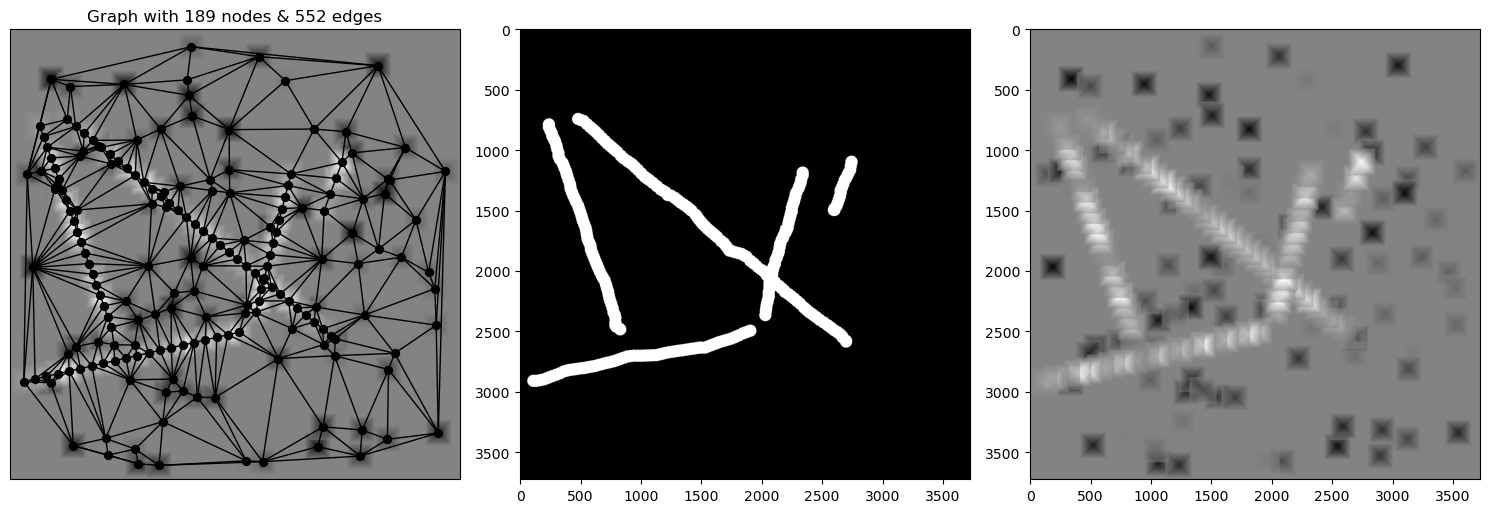

In [6]:
shape = 5
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(shape*3, shape*1))

plot_simple_graph(G, title=f"Graph with {G.number_of_nodes()} nodes & {G.number_of_edges()} edges", ax=axes[0])
axes[0].imshow(image, cmap="binary_r")
axes[1].imshow(annot, cmap="binary_r")
axes[2].imshow(image, cmap="binary_r")

plt.tight_layout()
plt.show()

### Features are now automatically appended to the image:

In [7]:
for idx, node in G.nodes(data=True):
    fea = node[GraphAttrs.NODE_FEATURES]
    print (fea.shape, fea.dtype, fea)
    break


torch.Size([2048]) torch.float32 tensor([0.8495, 0.4605, 0.8070,  ..., 0.4263, 0.3912, 0.4392])


In [8]:
data_whole_graph = dataset_from_graph(G, mode="whole")
data_whole_graph

[Data(x=[189, 2048], edge_index=[2, 552], y=[189], pos=[189, 2], edge_label=[552])]

### Nominate a pre-trained GCN model:

In [24]:
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-07-08/classifier.pt"
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-15-47/classifier.pt"
classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-07_17-30-51/classifier.pt"  # best Linear classifier
# classifier_filename = "/Users/kulicna/Desktop/classifier/runs/2023-09-08_15-11-58/classifier.pt"  # bad GCN + Linear classifier

pre_trained_gcn = torch.load(classifier_filename)
pre_trained_gcn.eval()


GCN(
  (node_classifier): Linear(in_features=2048, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=4096, out_features=2, bias=True)
)

### Chop off the last Linear layers:

In [25]:
def drop_linear_layers_from_model(model: torch.nn.Module) -> torch.nn.Sequential:
    """Chops off last 2 Linear layers from the classifier to 
    access node embeddings learnt by the GCN classifier."""

    modules = list(pre_trained_gcn.children())[:-2]
    node_emb_extractor = torch.nn.Sequential(*modules)
    for p in node_emb_extractor.parameters():
        p.requires_grad = False

    return node_emb_extractor


In [26]:
node_emb_extractor = drop_linear_layers_from_model(model=pre_trained_gcn)
node_emb_extractor

Sequential()

### Get the predictions:

In [27]:
def get_predictions_for_data_batches(
    model: torch.nn.Module, 
    data_batches: list[Data],
) -> tuple[torch.Tensor]:

    node_softmax_preds = []
    edge_softmax_preds = []
    node_argmax_preds = []
    edge_argmax_preds = []
    node_labels = []
    edge_labels = []

    # Predict labels from sub-graph:
    for data in tqdm(data_batches, desc="Predicting for the entire graph: "):

        # Get the ground truth labels:
        node_labels.extend(data.y)
        edge_labels.extend(data.edge_label)

        # Get the model predictions:
        node_x, edge_x = model.predict(x=data.x, edge_index=data.edge_index)
        print (node_x.shape, edge_x.shape)

        # Process node probs into classes predictions:
        node_soft = node_x.softmax(dim=1)
        node_softmax_preds.extend(node_soft)
        node_arg = node_soft.argmax(dim=1).long()
        node_argmax_preds.extend(node_arg)

        # Process edge probs into classes predictions:
        edge_soft = edge_x.softmax(dim=1)
        edge_softmax_preds.extend(edge_soft)
        edge_arg = edge_soft.argmax(dim=1).long()
        edge_argmax_preds.extend(edge_arg)

    # Stack the results:
    node_softmax_preds = torch.stack(node_softmax_preds, axis=0)
    edge_softmax_preds = torch.stack(edge_softmax_preds, axis=0)
    node_argmax_preds = torch.stack(node_argmax_preds, axis=0)
    edge_argmax_preds = torch.stack(edge_argmax_preds, axis=0)
    node_labels = torch.stack(node_labels, axis=0)
    edge_labels = torch.stack(edge_labels, axis=0)

    print(node_softmax_preds.shape, node_argmax_preds.shape, node_labels.shape)
    return node_softmax_preds, edge_softmax_preds, node_argmax_preds, edge_argmax_preds, node_labels, edge_labels


In [28]:
predicted_results = get_predictions_for_data_batches(model=pre_trained_gcn, data_batches=data_whole_graph)
node_probabs, edge_probabs, node_pred, edge_pred, node_true, edge_true = predicted_results


Predicting for the entire graph: 100%|██████████| 1/1 [00:00<00:00, 107.44it/s]

torch.Size([189, 2]) torch.Size([552, 2])
torch.Size([189, 2]) torch.Size([189]) torch.Size([189])


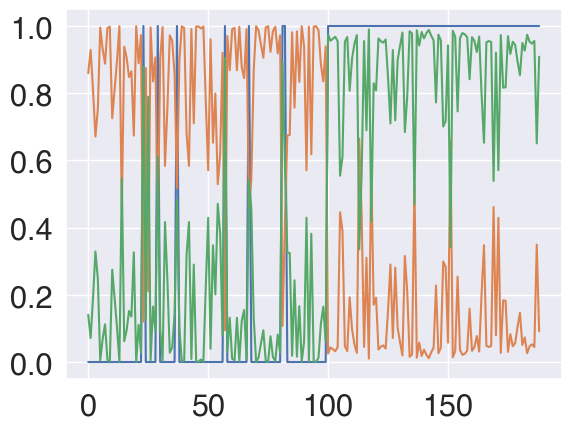

In [43]:
plt.plot(node_true)
plt.plot(node_probabs)
plt.show()

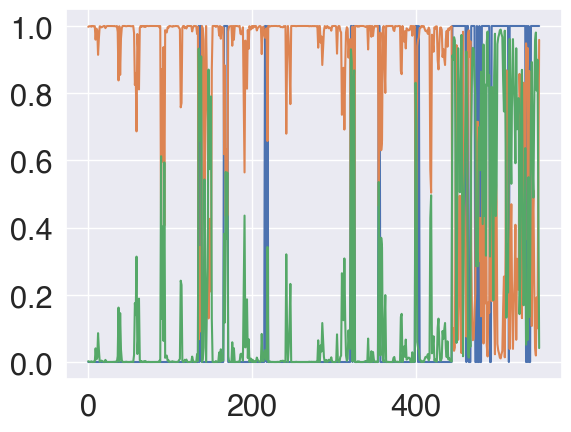

In [44]:
plt.plot(edge_true)
plt.plot(edge_probabs)
plt.show()

In [45]:
# # Investigate

# plt.scatter(x=node_pred, y=node_probabs[:, 0], color='firebrick', label='TN')
# plt.scatter(x=node_pred, y=node_probabs[:, 1], color='limegreen', label='TP')
# plt.title("Nodes")
# plt.legend()
# plt.show()

# plt.scatter(x=range(node_probabs.shape[0]), y=node_probabs[:, 0], color='firebrick', label='TN')
# plt.scatter(x=range(node_probabs.shape[0]), y=node_probabs[:, 1], color='limegreen', label='TP')
# plt.title("Nodes")
# plt.legend()
# plt.show()


# plt.scatter(x=edge_pred, y=edge_probabs[:, 0], color='firebrick', label='TN')
# plt.scatter(x=edge_pred, y=edge_probabs[:, 1], color='limegreen', label='TP')
# plt.title("Edges")
# plt.legend()
# plt.show()

# plt.scatter(x=range(edge_probabs.shape[0]), y=edge_probabs[:, 0], color='firebrick', label='TN')
# plt.scatter(x=range(edge_probabs.shape[0]), y=edge_probabs[:, 1], color='limegreen', label='TP')
# plt.title("Edges")
# plt.legend()
# plt.show()


## Evaluation:
### Simple metrics first:

In [30]:
from grace.evaluation.metrics_classifier import (
    accuracy_metric, 
    confusion_matrix_metric, 
    areas_under_curves_metrics,
)
from sklearn.metrics import ConfusionMatrixDisplay

In [31]:
node_acc, edge_acc = accuracy_metric(node_pred, edge_pred, node_true, edge_true)
node_acc, edge_acc

(0.9629629629629629, 0.9130434782608695)

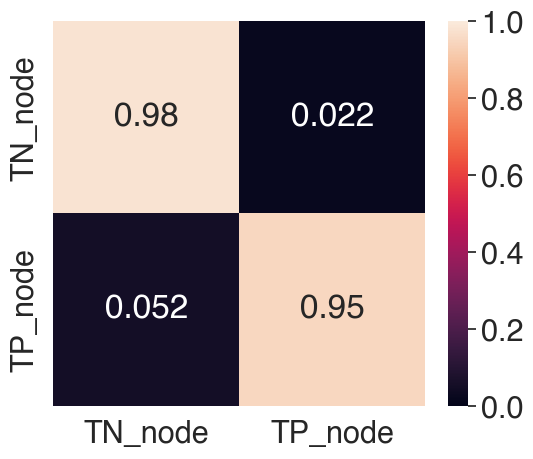

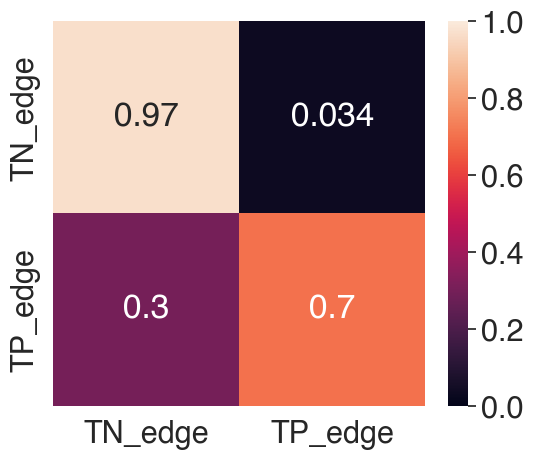

In [32]:
n_cm, e_cm = confusion_matrix_metric(node_pred, edge_pred, node_true, edge_true, normalize="true")

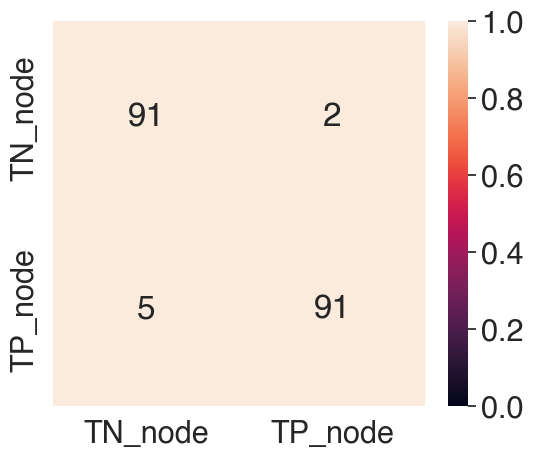

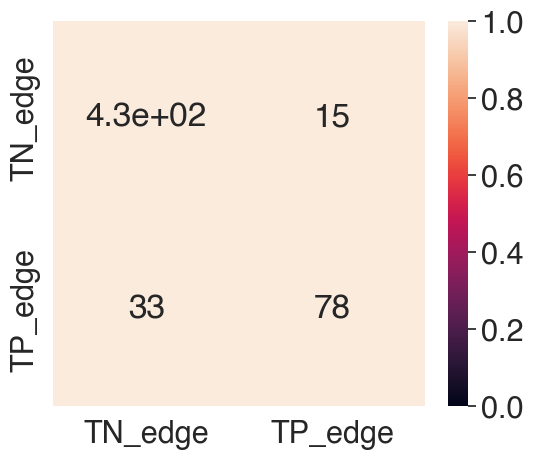

In [33]:
n_cm, e_cm = confusion_matrix_metric(node_pred, edge_pred, node_true, edge_true, normalize=None)

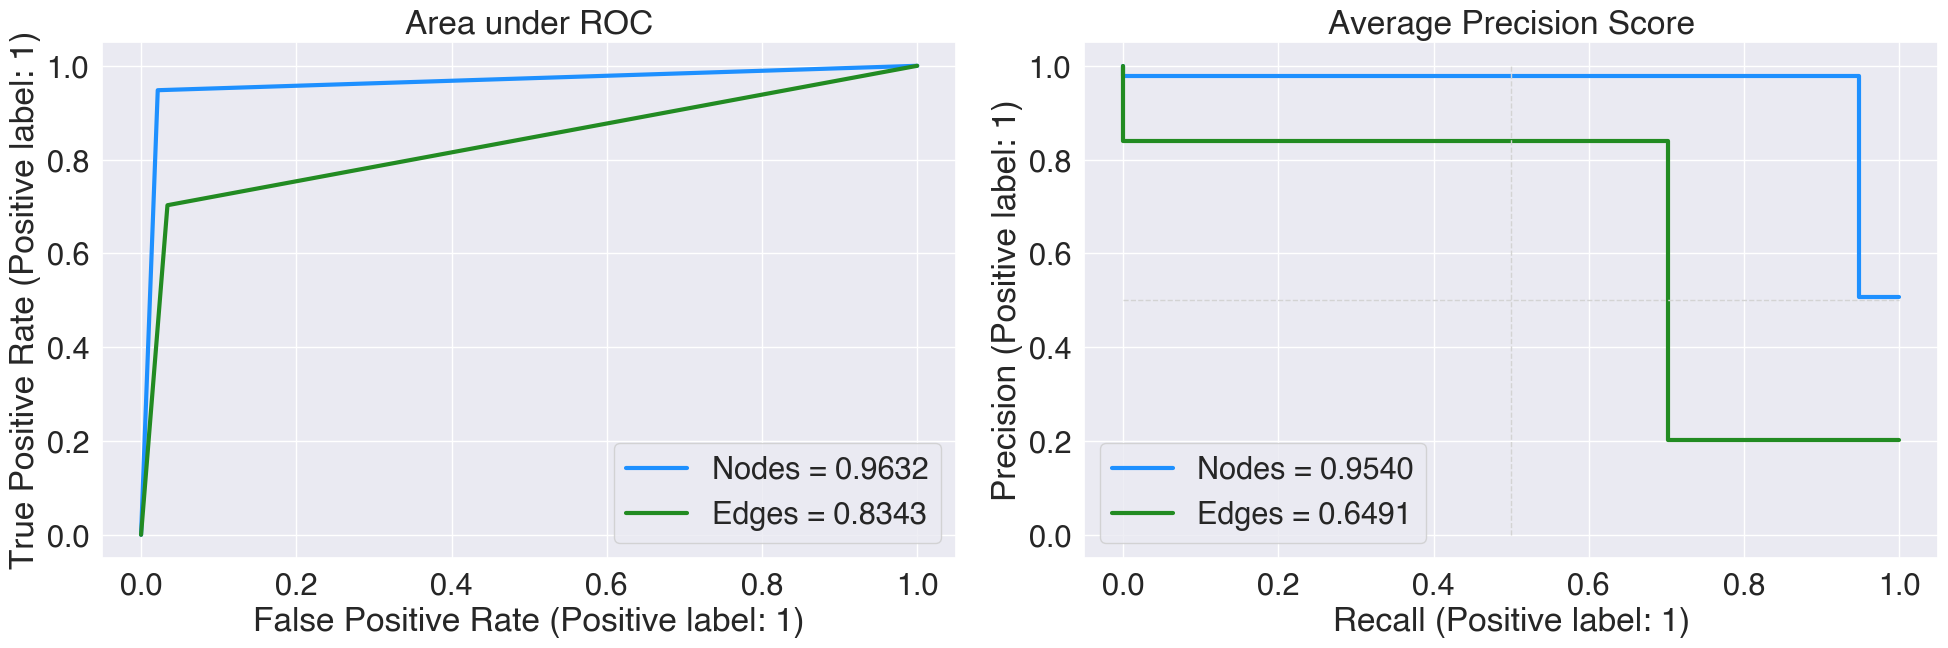

In [34]:
areas_fig = areas_under_curves_metrics(node_pred, edge_pred, node_true, edge_true)

### Possibly, display all 4 confusion matrices:

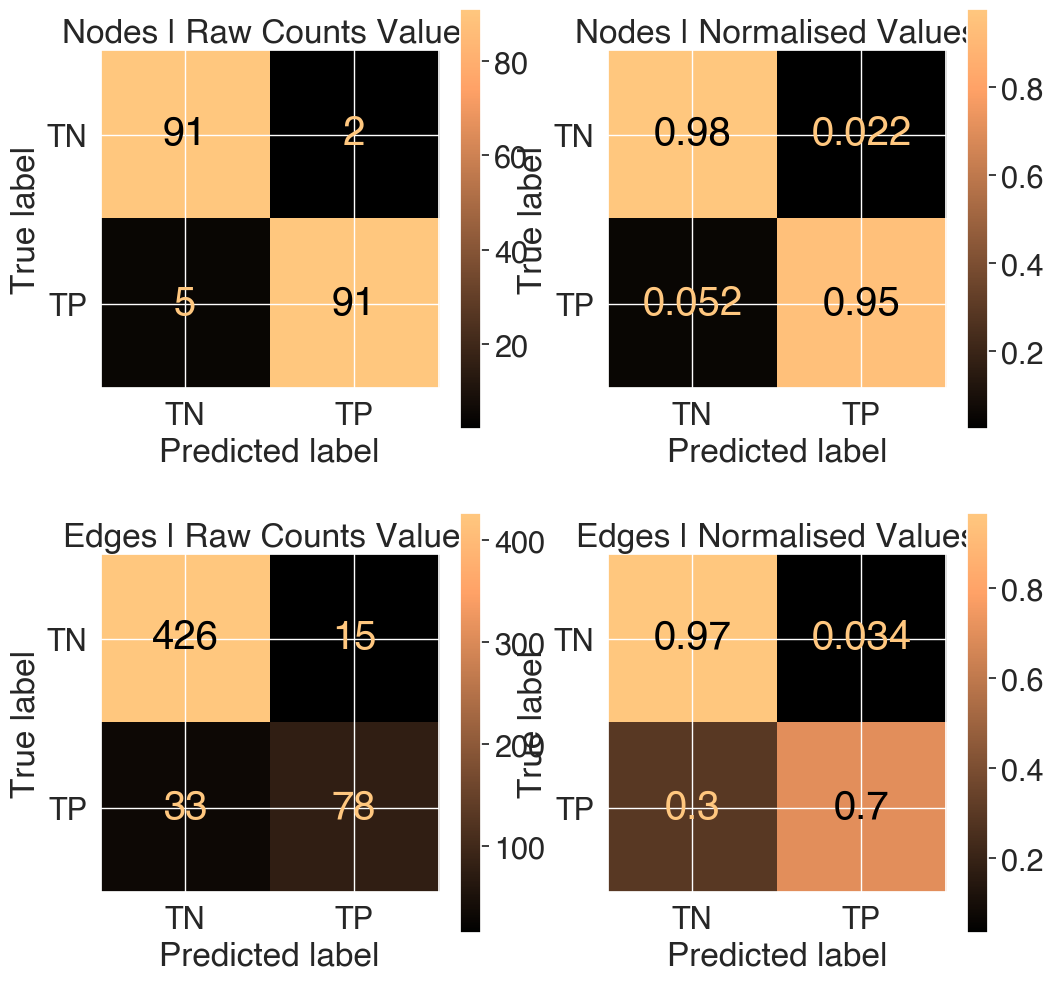

In [35]:
figsize = (12, 12)
colormap = "copper"
confusion_matrix_plotting_data = [
    [node_pred, node_true, "nodes"], 
    [edge_pred, edge_true, "edges"],
]

_, axs = plt.subplots(2, 2, figsize=figsize)

for d, matrix_data in enumerate(confusion_matrix_plotting_data):
    for n, nrm in enumerate([None, "true"]):
        ConfusionMatrixDisplay.from_predictions(
            y_pred=matrix_data[0],
            y_true=matrix_data[1],
            normalize=nrm,
            ax=axs[d, n],
            cmap=colormap,
            display_labels=["TN", "TP"],
            text_kw={"fontsize": "large"},
        )

        flag = "Raw Counts" if nrm is None else "Normalised"
        text = f"{matrix_data[2].capitalize()} | {flag} Values"
        axs[d, n].set_title(text)

plt.show()


##### Done!